In [1]:
import pyrootutils
root = pyrootutils.setup_root('.', pythonpath=True)
hydra_cfg_path = root / "CIFAR" / "configs"
os.chdir(root)

In [2]:
import omegaconf
from omegaconf import OmegaConf
import os
import hydra
from hydra import compose, initialize
from pathlib import Path
import torch
from models.wrn import WideResNet
from model_zoo.resnet import resnet32
from datamodule import get_ood_datasets
from test import prepair_datasets
from torch.utils.data import DataLoader

/home/cyanos/anaconda3/envs/ooddetection/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with initialize(version_base=None, config_path= '..' / hydra_cfg_path.relative_to(root) ):
    cfg = compose(config_name="eval", return_hydra_config=True, 
                 overrides=["ckpt_path=CIFAR/snapshots/pretrained/cifar10_wrn_pretrained_epoch_99.pt"])

In [4]:
DATA_ROOT = Path(os.environ['TORCH_DATASETS'])
train_data, test_data, NUM_CLASSES = prepair_datasets(cfg.in_dataset, DATA_ROOT)
OOD_DATA = get_ood_datasets(DATA_ROOT)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using CIFAR-10 as typical data


In [5]:
net = WideResNet(cfg.net.layers, NUM_CLASSES, 
                    cfg.net.widen_factor, dropRate=cfg.net.droprate)
# net = resnet32(3, 10, False)
# cfg.ckpt_path = "CIFAR/snapshots/new.pt"
net.load_state_dict(torch.load(cfg.ckpt_path))
print('Model restored! Checkpoint path:', cfg.ckpt_path)
net.eval()
if cfg.ngpu > 1:
    net = torch.nn.DataParallel(net, device_ids=list(range(cfg.ngpu)))
if cfg.ngpu > 0:
    net.cuda()
    # torch.cuda.manual_seed(1)

Model restored! Checkpoint path: CIFAR/snapshots/pretrained/cifar10_wrn_pretrained_epoch_99.pt


In [6]:
ind_loader = DataLoader(test_data, batch_size=cfg.test_bs, shuffle=False,
                            num_workers=cfg.prefetch, pin_memory=True)

In [147]:
net.cuda()
net.eval()
all_features = []
all_labels = []
ind_iter = iter(ind_loader)
n_repeat = 4
with torch.no_grad():
    for i in range(10):
        batch = next(ind_iter)
        images, labels = batch
        all_labels.append(labels)
        images, labels = images.cuda(), labels.cuda()
        net(images)
        features = net.get_features(pre_linear=False)
        # for _ in range(n_repeat):
        #     features = net.block3.layer[-2](features)
        #     features = net.block3.layer[-1](features)
        # features = net.flat_features(features)
        all_features.append(features)

all_features = torch.concat(all_features)
all_labels = torch.concat(all_labels)

ood_features = []
ood_labels = []
for ood_index, (ood_name, ood_data) in enumerate(OOD_DATA.items()):
    ood_loader = DataLoader(ood_data, 
                        batch_size=cfg.test_bs,
                        shuffle=False,
                        num_workers=cfg.prefetch, 
                        pin_memory=True)
    ood_iter = iter(ood_loader)
    with torch.no_grad():
        for i in range(2):
            batch = next(ood_iter)
            images, labels = batch
            ood_labels.append(labels.data.fill_(ood_index + 1))
            images, labels = images.cuda(), labels.cuda()
            net(images)
            features = net.get_features(pre_linear=False)
            # for _ in range(n_repeat):
            #     features = net.block3.layer[-2](features)
            #     features = net.block3.layer[-1](features)
            # features = net.flat_features(features)
            ood_features.append(features)
            
ood_features = torch.concat(ood_features)
ood_labels = torch.concat(ood_labels)

In [36]:
# all_features = all_features.clamp_(max=0.7)

In [148]:
all_features.shape

torch.Size([4000, 128])

In [75]:
import numpy as np
from sklearn import decomposition
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [149]:
ind_X = all_features.detach().cpu().numpy()
ind_y = all_labels.cpu().numpy()
ood_X = ood_features.detach().cpu().numpy()
ood_y = ood_labels.cpu().numpy()
softmax_weight = net.fc.weight.detach().cpu().numpy()
# y_training = all_preds.cpu().numpy()

### Average Norm

In [150]:
X_norms = np.linalg.norm(ind_X, axis=1, keepdims=True)
list_labels = np.arange(10)

In [151]:
lalels_ind = (np.expand_dims(ind_y, 1) == np.expand_dims(list_labels, 0))
X_norms_repeated = np.repeat(X_norms, 10, axis=1)
X_norms_labels_grouped = np.where(lalels_ind, X_norms_repeated, 0)

In [152]:
class_mean_norm = X_norms_labels_grouped.sum(axis=0) / (X_norms_labels_grouped > 0).sum(axis=0)
class_mean_norm = np.expand_dims(class_mean_norm, axis=1)

In [153]:
softmax_weight = ((softmax_weight / np.linalg.norm(softmax_weight, axis=1, keepdims=1))) * class_mean_norm

### Dimension Reduction

In [169]:
tmp_ind_X = ind_X @ softmax_weight.T 
tmp_ood_X = ood_X @ softmax_weight.T 
tmp_weight = softmax_weight @ softmax_weight.T 

In [182]:
# all_X = np.concatenate((ind_X, ood_X, softmax_weight), axis=0)
all_X = np.concatenate((tmp_ind_X, tmp_ood_X, tmp_weight), axis=0)
all_X = all_X / np.linalg.norm(all_X, axis=1, keepdims=1)

In [183]:
pca = decomposition.PCA(n_components=20)
all_X_reduced = pca.fit_transform(all_X)
# all_X_reduced = all_X

In [184]:
# np.sum( pca.explained_variance_ratio_ )

In [185]:
# softmax_weight_reduced = pca.transform(softmax_weight)
# X_n_softmax_weight_reduced = np.concatenate((X_training_reduced, softmax_weight_reduced), axis=0)

In [186]:
tsne = TSNE(n_components=2, init='random', learning_rate='auto')
all_X_reduced_tsne = tsne.fit_transform(all_X_reduced)

In [187]:
df = pd.DataFrame(all_X_reduced_tsne[:, :2], columns=['comp_1', 'comp_2'])
df['y'] = np.concatenate((ind_y, ood_y, np.arange(10)), axis=0)
df['dist'] = ['ind'] * ind_y.shape[0] + ['ood'] * ood_y.shape[0] + ['weight'] * 10
df['size'] = [10] * ind_y.shape[0] + [10] * ood_y.shape[0] + [100] * 10


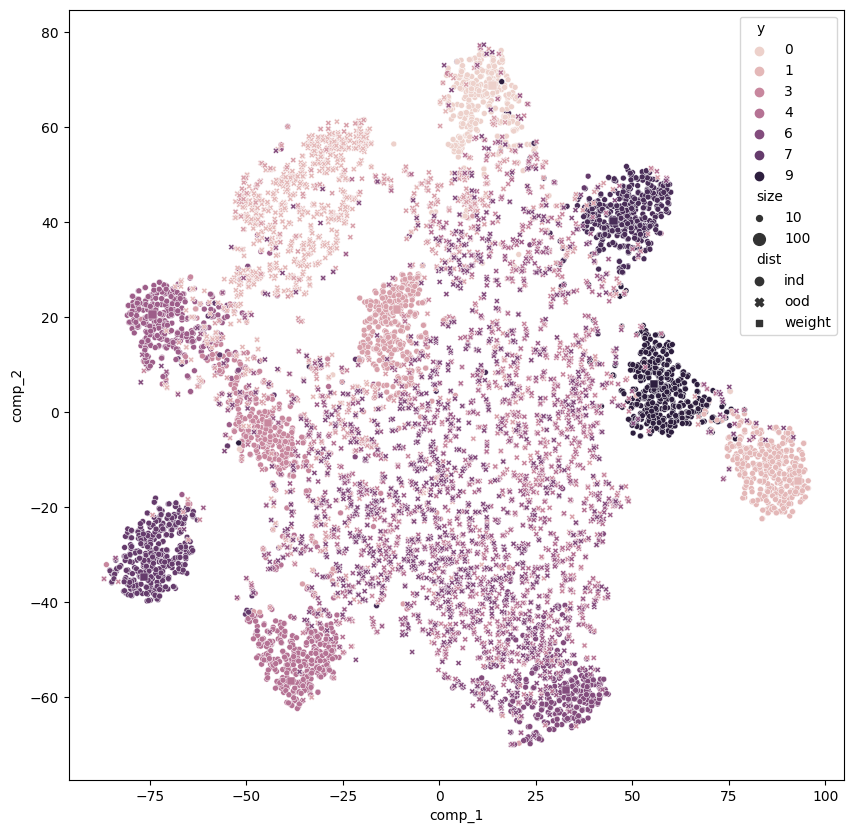

In [188]:
plt.figure( figsize=(10,10) )
# plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
sns.scatterplot(df, x='comp_1', y='comp_2', hue='y', style='dist', size='size')
plt.show()